# Volume 1: Facial Recognition
    Derek Robinson  
    Math 345
    12/2/2025

In [6]:
import os, zipfile
import numpy as np
from imageio.v3 import imread
from scipy import linalg as la
from matplotlib import pyplot as plt

## Helper Functions

In [7]:
def get_faces(path="./faces94.zip"):
    '''
    Traverse the specified directory (or zip file) to obtain one image from each subfolder,
    convert each image to grayscale, flatten it, and stack them as columns
    of a data matrix.

    Parameters
    ----------
    path : str
        Directory path (or zip archive) containing the faces94 dataset.

    Returns
    -------
    F : ndarray
        Each column of F is a vectorized face image (flattened to 1D).
    '''
    faces = []        # List to store flattened face images.
    subs = set()      # Track which subfolders have been sampled.

    # Open the zip file containing the dataset.
    with zipfile.ZipFile(path, 'r') as z:
        for info in z.infolist():
            # Skip directories (only process files).
            if info.is_dir():
                continue

            # Only take the *first* image from each subdirectory.
            dn = os.path.dirname(info.filename)
            if dn in subs:
                continue

            # Only process jpg images.
            if not info.filename.lower().endswith("jpg"):
                continue

            subs.add(dn)

            # Read the image from the archive, convert to grayscale, flatten.
            face = imread(z.read(info.filename)).mean(axis=2).ravel()
            faces.append(face)
    
    # Stack face vectors as columns in matrix F.
    return np.transpose(faces)


def sample_faces(k, path="./faces94.zip"):
    """Generate k sample images from the given path.

    Parameters
    ----------
    n (int):
        The number of sample images to obtain. 
    path(str):
        The directory containing the dataset of images.  
    
    Yields
    ------
    ((mn,) ndarray):
        An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = [] # List to store possible files.

    # Open the zip file containing the dataset.
    with zipfile.ZipFile(path) as z:
        for info in z.infolist():

            # Only process jpg images.
            if not info.filename.lower().endswith("jpg"):
                continue

            # Store files to be sampled.
            files.append(info.filename)

        # Choose k files.
        test_files = np.random.choice(files, k, replace=False)

        # Read and yield the images.
        for fname in test_files:
            yield imread(z.read(fname)).mean(axis=2).ravel()

## Problem 1 

- Implement `show()`.
- Use `show()` to display a face from the `faces94` dataset.

In [8]:
def show(image, m=200, n=180):
    """
    Plot the flattened grayscale 'image' of width n and height m.

    Parameters
    ----------
    image : 1D ndarray
        Flattened vector representing an image.
    m : int
        Number of rows (height) of the image.
    n : int
        Number of columns (width) of the image.

    Returns
    -------
    None
    """
    original = np.reshape(image, (m, n))
    plt.imshow(original, cmap="gray")
    plt.axis("off")
    plt.show()

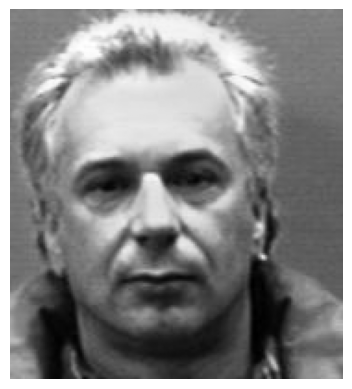

In [9]:
F = get_faces()
h, w = 200, 180
show(F[:, 78], h, w)

In [ ]:
class FacialRec(object):
    """
    A class for storing a database of face images, with methods for
    matching other faces to the database.

    Attributes
    ----------
    F : (mn, k) ndarray
        Matrix where each column is a flattened image (one per subject).
    mu : (mn,) ndarray
        Mean face vector (average of all images).
    Fbar : (mn, k) ndarray
        Centered images (each image minus the mean face).
    U : (mn, k) ndarray
        Left singular vectors (eigenfaces) from the compact SVD of Fbar.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """
        Load the database, compute the mean face, mean-shifted faces,
        and eigenfaces via SVD.

        Parameters
        ----------
        path : str
            Path to the faces94 dataset archive.
        """
        #load images
        self.F = get_faces(path)
        #mean face
        self.mean = np.mean(self.F, axis=1)
        #f bar
        self.f_bar = self.F - self.mean[:, None]
        #for showing
        self.h, self.w = 200, 180
        self.U, self.S, self.vt = np.linalg.svd(self.f_bar, full_matrices=False)
    # Problem 3
    def project(self, A, s):
        """
        Project a face or matrix of faces onto the subspace spanned
        by the first s eigenfaces (columns of U).

        Parameters
        ----------
        A : (mn,) or (mn, l) ndarray
            The image(s) to be projected (flattened).
        s : int
            Number of eigenfaces to use for projection.

        Returns
        -------
        (s,) or (s, l) ndarray
            Coefficients of the projection(s) in the eigenface basis.
        """

        return self.U[:, :s].T @ A
    # Problem 5
    def find_nearest(self, g, s=38):
        """
        Find the database image closest (in eigenface space) to the given face.

        Parameters
        ----------
        g : (mn,) ndarray
            Flattened test image.
        s : int, optional
            Number of eigenfaces to use in the projection (default 38).

        Returns
        -------
        int
            Index of the closest match in the database.
        """
        #get the nearest equations
        g_bar = g - self.mean
        g_hat = self.project(g_bar, s)
        F_hat = self.project(self.f_bar, s)
        dists = la.norm(F_hat - g_hat.reshape(-1, 1), axis=0)

        return np.argmin(dists)
        

    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """
        Display the input image alongside its closest database match.

        Parameters
        ----------
        image : (mn,) ndarray
            The input (flattened) face image.
        s : int, optional
            Number of eigenfaces to use for projection (default 38).
        m : int, optional
            Number of rows in the image (default 200).
        n : int, optional
            Number of columns in the image (default 180).

        Returns
        -------
        None
        """
        
        nearest_idx = self.find_nearest(image, s=38)
        
        #get matching face
        matched_face = self.F[:, nearest_idx]

        #reshape
        img1 = np.reshape(image, (self.h, self.w))
        img2 = np.reshape(matched_face, (self.h, self.w))

        plt.subplot(1, 2, 1)
        plt.imshow(img1, cmap="gray")
        plt.title("Input image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img2, cmap="gray")
        plt.title("closest match")
        plt.axis("off")

        plt.show()
        



## Problem 2

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

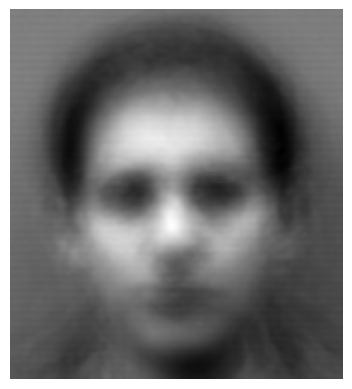

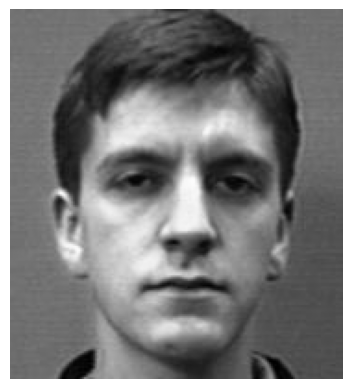

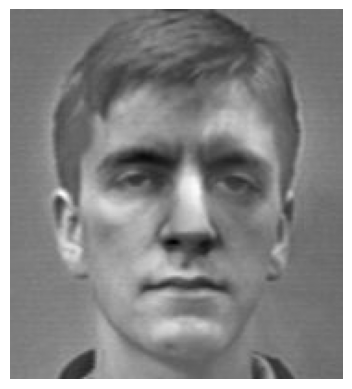

In [ ]:
fr = FacialRec("./faces94.zip")
i = 90
#testing all the types of images
show(fr.mean, fr.h, fr.w)



show(fr.F[:, i], fr.h, fr.w)

show(fr.f_bar[:, i], fr.h, fr.w)



## Problem 3

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


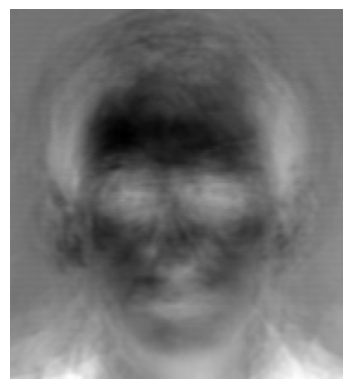

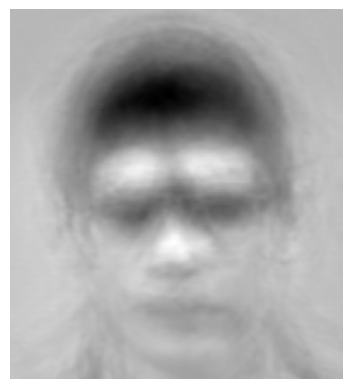

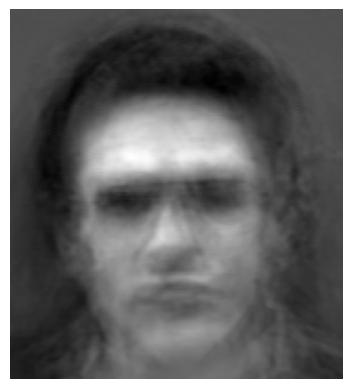

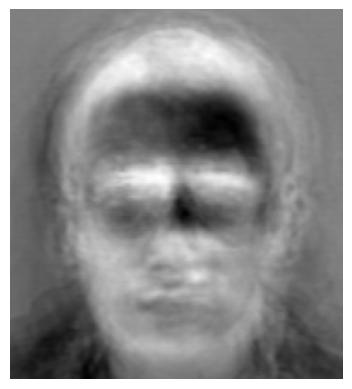

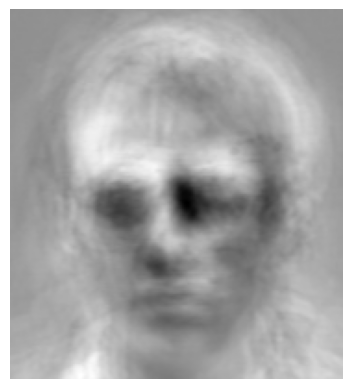

In [12]:
for k in range(5):
    #col of u
    plt.imshow(fr.U[:, k].reshape(fr.h, fr.w), cmap='gray')
    plt.axis("off")
    plt.show()


## Problem 4

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

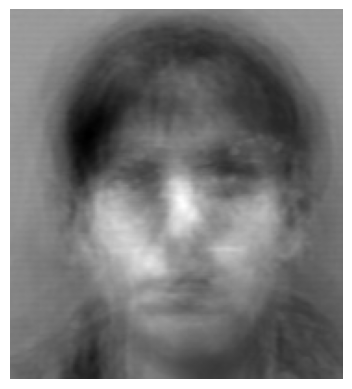

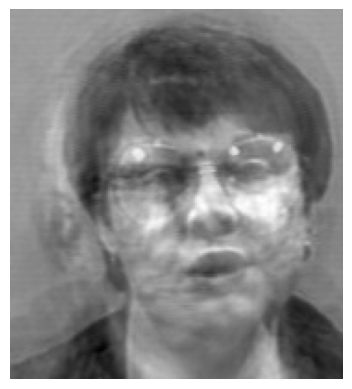

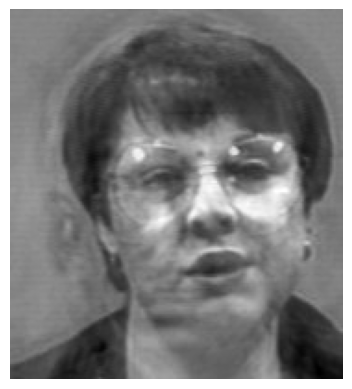

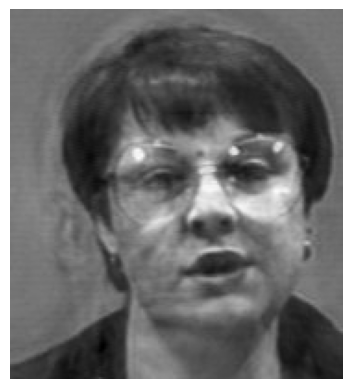

In [ ]:

fr = FacialRec("faces94.zip")
f_i = fr.f_bar[:, 0]

s_vals = [5, 15, 25, 35]
#following equations
for s in s_vals:
    coeffs = fr.project(f_i, s)

    #this is the equation
    f_i_reconstruct = fr.U[:, :s] @ coeffs + fr.mean
    img = show(f_i_reconstruct, fr.h, fr.w)

## Problem 5 
Implement `FacialRec.find_nearest()`.

## Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

Testing face #0


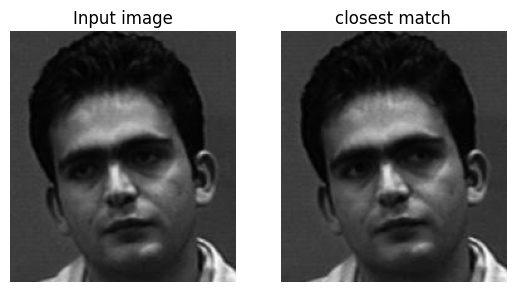

Testing face #1


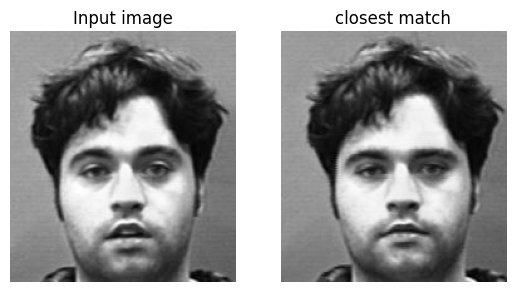

Testing face #2


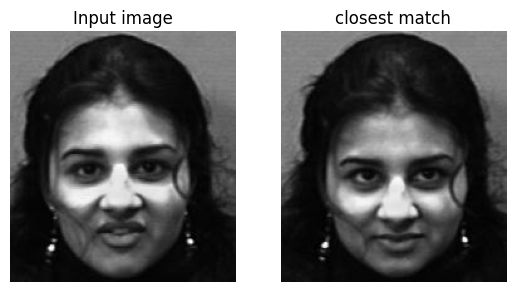

Testing face #3


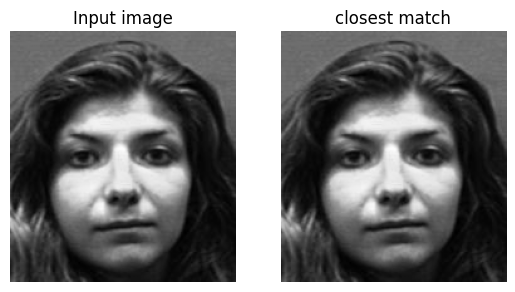

Testing face #4


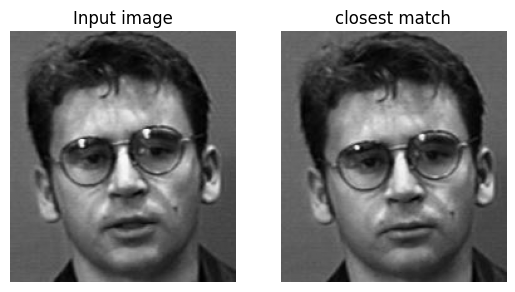

In [ ]:
def sample_faces(k, path="./faces94.zip"):
    """Generate k sample images from the given path.

    Parameters
    ----------
    n (int):
        The number of sample images to obtain.
    path(str):
        The directory containing the dataset of images.

    Yields
    ------
    ((mn,) ndarray):
        An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = [] # List to store possible files.

    # Open the zip file containing the dataset.
    with zipfile.ZipFile(path) as z:
        for info in z.infolist():

            # Only process jpg images.
            if not info.filename.lower().endswith("jpg"):
                continue

            # Store files to be sampled.
            files.append(info.filename)

        # Choose k files.
        test_files = np.random.choice(files, k, replace=False)

        # Read and yield the images.
        for fname in test_files:
            yield imread(z.read(fname)).mean(axis=2).ravel()
fr = FacialRec("./faces94.zip")
k = 5

#list of arrays
images = list(sample_faces(k))   

for i, img in enumerate(images):
    print(f"Testing face #{i}")
    fr.match(img)  # shows side-by-side comparison


